**Lab 4: FIR filters and envelopes**

The goal of this lab is to learn how to implement FIR filters in Python, and how we can use them to improve our synthesis.

In [16]:
import os
import numpy as np
import librosa
import IPython.display as ipd
from scipy import signal
import matplotlib.pyplot as plt

from util import load_audio, plot_signals, plot_spectrogram, plot_mean_spectrogram

**1. Overview of Filtering**

For this lab, we will define an FIR filter as a discrete-time system that converts an input signal $x[n]$ into an output signal $y[n]$ by means of the weighted summation:

$$
y[n] = \sum_{k=0}^M b_kx[n-k]
$$

The function *np.convolve()* is a generic function with which to implement FIR filters. The following code implements a three-point averaging system:

In [17]:
fs = 1
x = [np.floor(x/10) for x in range(50)]
b = np.array([1.0/3, 1.0/3, 1.0/3])
y = np.convolve(b, x)

plot_signals([x, y], fs, name=['input x[n]', 'output y[n]'], mode='lines+markers')

1.1 Explain the filtering action of the 5-point averager by comparing the plot of the input $x[n]$ and the output $y[n]$. This filter might be called a “smoothing” filter. Note how the transitions from one level to another have been “smoothed.”

The 5-point averager, is used to smooth or average a signal. It operates by averaging the current sample and four previous samples from the input signal to create a smoother output. This filtering action reduces the impact of high-frequency noise and sharp transitions in the input. We can see this from the example above by noteching how the transitions last longer and have less of an angle of attack. It's an overall smoother graphic than the blue one.

*1.2* Define a function `averaging_filter(x, N)` which implements the N-points averaging filter using the `np.convolve` function.

In [18]:
import numpy as np

def averaging_filter(x, N):
    """
    Applies a N-point averaging filter to the input signal x

    Parameters
    ----------
    x : np.array
        The input signal in the form of a numpy array
    N : int
        The number of points used in N-point averaging filter

    Returns
    -------
    y : np.array
        The output of the filter
    """
    # Create an array to store the filter coefficients
    b = np.ones(N) / N  # Initialize with 1/N repeated N times

    # Convolve the input signal with the filter coefficients
    y = np.convolve(b, x, mode='valid')  # Use 'valid' mode to match the output length

    return y

# Example usage:
input_signal = np.array([1, 2, 3, 4, 10, 6, 7, 8, 9])
N = 3
filtered_signal = averaging_filter(input_signal, N)
print("Input Signal:", input_signal)
print("Filtered Signal:", filtered_signal)



Input Signal: [ 1  2  3  4 10  6  7  8  9]
Filtered Signal: [2.         3.         5.66666667 6.66666667 7.66666667 7.
 8.        ]


1.3 Run the example above using the `averaging_filter` instead. Change the number N to different values and explain what happen.

In [19]:
# Write your code here
a = averaging_filter(x, 5)
b = averaging_filter(x, 6)
c = averaging_filter(x, 7)
plot_signals([a, b, c], fs, name=['N = 5', 'N = 6', 'N = 7'], mode='lines+markers')



In [20]:
import numpy as np
import matplotlib.pyplot as plt
# we wanted to observe better the effects of FIR on a more real signal, that's this code

# Parameters
n_samples = 500  # Number of samples
t = np.linspace(0, 10, n_samples)  # Time vector
frequency = 1.0  # Frequency of the sine wave (in Hz)
amplitude = 1.0  # Amplitude of the sine wave
noise_stddev = 0.2  # Standard deviation of noise

# Generate a noisy sine wave signal
x = amplitude * np.sin(2 * np.pi * frequency * t) + noise_stddev * np.random.randn(n_samples)
a = averaging_filter(x, 5)
b = averaging_filter(x, 6)
c = averaging_filter(x, 7)
plot_signals([x, a, b, c], fs, name=['normal signal','N = 5', 'N = 6', 'N = 7'], mode='lines+markers')


1.4 How would you classify this filter, as a low-pass o high-pass filter?

it smooths the signal by averaging a range of samples, which effectively reduces the impact of high-frequency noise or rapid changes in the signal. This behavior makes it a low-pass filter, as it passes the lower-frequency components and attenuates the higher-frequency components, resulting in a smoother signal.







---

**2. Envelope detector**

Now we'll implement an envelope detector by concatenating two systems: a full-wave rectifier (absolute value) and the N-point averaging filter.

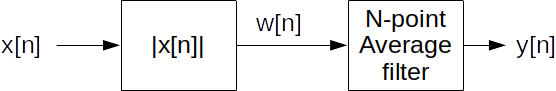

2.1 Define a function `envelope(x, N)` which applies an N-point averaging filter to the full-wave rectified signal and returns the output $y[n]$.

**Note 1**: to calculate the full-wave rectified signal check the `np.abs()` function.

**Note 2**: The output should have the same length as the input signal. Use 'same' mode (see [np.convolve](https://numpy.org/doc/stable/reference/generated/numpy.convolve.html) documentation).

In [21]:

def envelope(x, N):
    """
    Extracts the envelope of the input signal x by concatenating a full-wave rectifier and an N-point averaging filter.

    Parameters
    ----------
    x : np.array
        The input signal in the form of a numpy array
    N : int
        The number of points used in N-point averaging filter

    Returns
    -------
    y : np.array
        The output of the system, i.e., the envelope of the signal x.
    """
    if N < 1:
      raise ValueError("N must be at least 1")

    # Step 1: Full-wave rectifier (absolute value)
    rectified_signal = np.abs(x)

    # Step 2: Apply N-point averaging filter to the rectified signal
    filter_coeffs = np.ones(N) / N
    envelope_signal = np.convolve(rectified_signal, filter_coeffs, mode='same')

    return envelope_signal
#This function first calculates the full-wave rectified signal by taking the absolute value of the input signal x. Then, it applies an N-point averaging filter to the rectified signal, resulting in the envelope of the input signal. The output has the same length as the input signal, as specified in the docstring.




2.2 Load your reference signal and calculate its envelope using the function you designed. Plot the reference signal and envelope in the same figure.

In [22]:
# Write your code here
#!git clone https://github.com/FrancescXarrie/-sis1_group4.git
filepath = "./-sis1_group4/44733__casualdave__601e.wav"
ref, fs = load_audio(filepath)
import numpy as np
import matplotlib.pyplot as plt
# we wanted to observe better the effects of FIR on a more real signal, that's this code

# Parameters
n_samples = 500  # Number of samples
t = np.linspace(0, 10, n_samples)  # Time vector
frequency = 1.0  # Frequency of the sine wave (in Hz)
amplitude = 1.0  # Amplitude of the sine wave
noise_stddev = 0.2  # Standard deviation of noise

# Generate a noisy sine wave signal
x = amplitude * np.sin(2 * np.pi * frequency * t) + noise_stddev * np.random.randn(n_samples)
a = averaging_filter(x, 5)
b = averaging_filter(x, 6)
c = averaging_filter(x, 7)
plot_signals([x, a, b, c], fs, name=['normal signal','N = 5', 'N = 6', 'N = 7'], mode='lines+markers')

2.3 Change the number N to get a good result. What happens when you change the number N?

The signal gets smoother since we are averaging more points at the same time

2.4 Explain with your own words why this system achieves extracting the envelope. It might be useful to plot together the signals $x[n]$, $w[n]$ and $y[n]$.

The envelope function (due to its main components: the full-wave rectifier and the N-point averaging filter) smoothes the function to clearly show it's limits in the time domain (maximum and minimum y(t))

2.5 Now let's apply this envelope to the synthesized signal. Copy the code from Lab3 Ex. 2.1 and generate the synthesized signal. Then multiply the synthesized signal by the envelope. Note that both signal and envelope should have the same length. You can define a time vector of the same length of the envelope to create the signal:

In [28]:
Ts = 1/float(fs)
env = envelope(fs, 8)
t = np.arange(0, len(env)*Ts, Ts)

# From lab 3
weights = [0.834, 1, 0.865, 0.224, 0.034, 0.119, 0.054, 0.016, 0.028] 

def synthesize(f0, phi, Ak, t):
  y = 0
  for k in range(1, len(Ak) + 1):
    y += Ak[k-1] * np.cos(2*np.pi*k*f0*t + k*phi - (k-1)*np.pi/2)
  return y

f0 = 43.65
phi = np.pi*2/35
y = synthesize(f0, phi, weights, t)
plot_signals(env, fs, t_start=0.763, t_end=0.763+7+t)
plot_signals(y, fs, t_start=0.763, t_end=0.763+7+t)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

2.6. Compare the spectrograms of the reference signal and the synthesized signal. What are the main differences?

In [ ]:
# Write your code here
# Write the code here
# plot the spectrogram
window_length = 8192*2
ff, tt, Sy = signal.spectrogram(y, fs, nperseg=window_length, noverlap=window_length/2)
ff, tt, S = signal.spectrogram(ref, fs, nperseg=window_length, noverlap=window_length/2)
plt.figure(figsize=(10,8))
plot_spectrogram(ff, tt, S)
ff, tt, Sy = signal.spectrogram(y, fs, nperseg=window_length, noverlap=window_length/2)
plot_spectrogram(ff, tt, Sy)
plt.ylim([0, 500])
plt.show()

# The main difference is that the composed signal is lacking higher frequencies, this can also be observed from the spectrum. Also there is no decay over time.
# But aside frm this and the length of the audio, the rest is quite similar



2.7 Listen to the synthesized signal and compare it to the reference.



In [ ]:
# Write your code here
from IPython.lib.display import Audio
# Write the code here
Audio(y, rate=fs)


In [ ]:
Audio(ref, rate=fs)